# August stim analysis, 2021

**Motivation**: Stim <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
mode = 'bold'
metric = 'pearson'
match_metric = 'cosine'

## Clf task

In [3]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

def softmax(z, axis=0):
    e = np.exp(z)
    return e / e.sum(axis, keepdims=True)

### LED

In [4]:
adj_all = {}
within_all = {}
between_all = {}

In [5]:
task = 'led'
mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

for key in tqdm(mice.bold_combined):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    wit, bet = net.get_hemisphere_adj(net.percentiles[0])
    np.fill_diagonal(wit, 0.)
    within_all[f"{task}:{key}"] = wit
    between_all[f"{task}:{key}"] = bet
    adj_all[f"{task}:{key}"] = net.adj

  0%|          | 0/134 [00:00<?, ?it/s]

### REST

In [6]:
task = 'rest'
mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

for key in tqdm(mice.bold_combined):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    wit, bet = net.get_hemisphere_adj(net.percentiles[0])
    np.fill_diagonal(wit, 0.)
    within_all[f"{task}:{key}"] = wit
    between_all[f"{task}:{key}"] = bet
    adj_all[f"{task}:{key}"] = net.adj

  0%|          | 0/158 [00:00<?, ?it/s]

In [7]:
rng = get_rng(42)
selected_keys = [k for k in within_all if 'run' in k]
rng.shuffle(selected_keys)

In [8]:
led_ids = [i for i, k in enumerate(selected_keys) if 'led' in k]
rest_ids = [i for i, k in enumerate(selected_keys) if 'rest' in k]
led_ids, rest_ids = np.array(led_ids), np.array(rest_ids)

y = np.zeros(len(selected_keys))
y[led_ids] = 1

In [9]:
region_overlap = mice.parcel.get_region_overlap(30)

  0%|          | 0/64 [00:00<?, ?it/s]

In [10]:
include = []
for region, x in region_overlap.items():
    if 'VIS' in x and region <= 32:
        include.append(region - 1)

In [11]:
x = []
for k in selected_keys:
    a_wit = within_all[k]
    dim = len(a_wit)
    triu_ind = np.triu_indices(dim)
    tril_ind = np.tril_indices(dim)
    
    a_r = a_wit.copy()
    a_l = a_wit.copy()
    a_r[tril_ind] = np.nan
    a_l[triu_ind] = np.nan

    f = (a_r.T - a_l) ** 2
    f = f[include][:, include]
    x.append(f.reshape(1, -1))
x = np.concatenate(x)
nan_ids = np.isnan(x).sum(0).astype(bool)
x[:, nan_ids] = 0.0

len(led_ids), len(rest_ids), y.shape, x.shape

(90, 114, (204,), (204, 25))

<matplotlib.colorbar.Colorbar object at 0x7f03434ebb80>

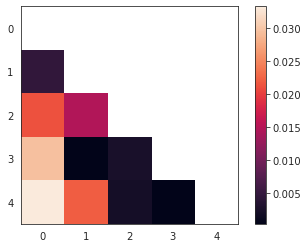

In [12]:
plt.imshow(f)
plt.colorbar()

In [13]:
xv_folds = 10
seeds = [2**i for i in range(0, 30)]

dict_list = []
for which_fold in tqdm(range(xv_folds)):
    led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
    rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

    led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
    rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

    tst = np.concatenate([led_tst, rest_tst])
    trn = np.concatenate([led_trn, rest_trn])
    assert not set(tst).intersection(set(trn))
    
    for C in np.logspace(-2, 0.5, 31):
        for seed in seeds:
            lr = LogisticRegression(
                penalty='l2',
                C=C,
                class_weight='balanced',
                solver='lbfgs',
                max_iter=int(1e7),
                tol=1e-6,
                random_state=seed,
            ).fit(x[trn], y[trn])
            y_pred = lr.predict(x[tst])

            data_dict = {
                'seed': [seed] * 3,
                'fold': [which_fold] * 3,
                'C': [C] * 3,
                'metric': ['matthews', 'accuracy', 'f1'], 
                'score': [
                    matthews_corrcoef(y[tst], y_pred),
                    accuracy_score(y[tst], y_pred),
                    f1_score(y[tst], y_pred)], 
            }
            dict_list.append(data_dict)

perf = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/10 [00:00<?, ?it/s]

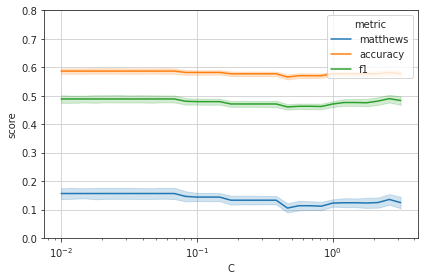

In [14]:
fig, ax = create_figure(1, 1, (6, 4), 'ticks')

sns.lineplot(
    data=perf,
    x='C',
    y='score',
    hue='metric',
    ax=ax,
)
ax.grid()
ax.set_ylim(0, 0.8)
ax.set_xscale('log')
plt.show()

In [15]:
_df = perf.loc[perf.metric == 'matthews'].groupby(['C', 'fold']).mean()
_df.score.argmax()

0

In [16]:
_df.index[_df.score.argmax()]

(0.01, 0)

In [17]:
C, which_fold = _df.index[_df.score.argmax()]

In [18]:
led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

tst = np.concatenate([led_tst, rest_tst])
trn = np.concatenate([led_trn, rest_trn])
assert not set(tst).intersection(set(trn))

In [19]:
lr = LogisticRegression(
    penalty='l2',
    C=C,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=int(1e7),
    tol=1e-6,
    random_state=42,
).fit(x[trn], y[trn])
y_pred = lr.predict(x[tst])

In [20]:
matthews_corrcoef(y[tst], y_pred)

0.5095246653650681

In [21]:
r = permutation_importance(
    estimator=lr,
    X=x[tst],
    y=y[tst],
    n_repeats=50,
    random_state=0,
)

In [22]:
region_overlap = mice.parcel.get_region_overlap()

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
features_sorted = r.importances_mean.argsort()[::-1]
for ii in range(20):
    i, j = np.unravel_index(features_sorted[ii], net.adj.shape)
    li, lj = net.n2l[i].split('-'), net.n2l[j].split('-')
    ri, rj = int(li[-1]), int(lj[-1])
    if '315' in li and '315' in lj:
        print(features_sorted[ii], i, j, '\n', region_overlap[ri], region_overlap[rj], '\n\n') 

## Identify!

In [24]:
xv_folds = 10
seeds = [2**i for i in range(30)]

dict_list = []
dict_list_perf = []
for which_fold in tqdm(range(xv_folds)):
    for seed in seeds:
        rng = get_rng(seed)
        selected_keys = [k for k in within_all if 'run' in k]
        rng.shuffle(selected_keys)

        led_ids = [i for i, k in enumerate(selected_keys) if 'led' in k]
        rest_ids = [i for i, k in enumerate(selected_keys) if 'rest' in k]
        led_ids, rest_ids = np.array(led_ids), np.array(rest_ids)
        
        led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
        rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

        led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
        rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

        tst = np.concatenate([led_tst, rest_tst])
        trn = np.concatenate([led_trn, rest_trn])
        assert not set(tst).intersection(set(trn))

        y = np.zeros(len(selected_keys))
        y[led_ids] = 1
        
        x = []
        for k in selected_keys:
            a_wit = within_all[k]
            dim = len(a_wit)
            triu_ind = np.triu_indices(dim)
            tril_ind = np.tril_indices(dim)

            a_r = a_wit.copy()
            a_l = a_wit.copy()
            a_r[tril_ind] = np.nan
            a_l[triu_ind] = np.nan

            f = np.abs(a_r.T - a_l)
            f = f[include][:, include]
            x.append(f.reshape(1, -1))
        x = np.concatenate(x)
        nan_ids = np.isnan(x).sum(0).astype(bool)
        x[:, nan_ids] = 0.0

        for C in np.logspace(-4, -1, 31):
            lr = LogisticRegression(
                penalty='l2',
                C=C,
                class_weight='balanced',
                solver='lbfgs',
                max_iter=int(1e7),
                tol=1e-6,
                random_state=seed,
            ).fit(x[trn], y[trn])
            y_pred = lr.predict(x[tst])
            confidence = lr.decision_function(x[tst])
            
            data_dict = {
                'seed': [seed] * 3,
                'fold': [which_fold] * 3,
                'C': [C] * 3,
                'metric': ['matthews', 'accuracy', 'f1'], 
                'score': [
                    matthews_corrcoef(y[tst], y_pred),
                    accuracy_score(y[tst], y_pred),
                    f1_score(y[tst], y_pred)], 
            }
            dict_list_perf.append(data_dict)
            
            for idx, i in enumerate(tst):
                task, key = selected_keys[i].split(':')
                correct = not (bool(y[i]) ^ bool(y_pred[idx]))
                data_dict = {
                    'seed': [seed],
                    'fold': [which_fold],
                    'C': [C],
                    'confidence': [confidence[idx]],
                    'correct': [int(correct)], 
                    'task': [task],
                    'key': [key],
                }
                dict_list.append(data_dict)

perf = pd.DataFrame(merge_dicts(dict_list_perf))
result = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/10 [00:00<?, ?it/s]

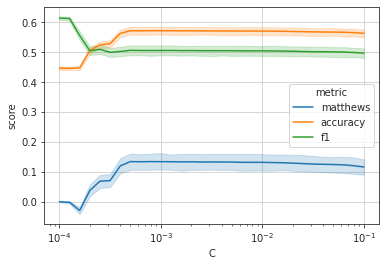

In [25]:
sns.lineplot(data=perf, x='C', y='score', hue='metric')
plt.grid()
plt.xscale('log')

In [26]:
_df = perf.loc[perf.metric == 'matthews'].groupby(['C']).mean()
_df.score.argmax()
best_c = _df.index[_df.score.argmax()]
best_c

0.0005011872336272725

In [27]:
result = result.loc[result.C == best_c]
result

,seed,fold,C,confidence,correct,task,key
147,1,0,0.000501,0.000097,1,led,sub-SLC02_ses-3_run-6
148,1,0,0.000501,-0.000401,0,led,sub-SLC04_ses-2_run-2
149,1,0,0.000501,-0.000297,0,led,sub-SLC04_ses-1_run-2
150,1,0,0.000501,-0.000566,0,led,sub-SLC05_ses-2_run-2
151,1,0,0.000501,0.000304,1,led,sub-SLC05_ses-1_run-4
...,...,...,...,...,...,...,...
189370,536870912,9,0.000501,-0.000204,1,rest,sub-SLC08_ses-3_run-7
189371,536870912,9,0.000501,-0.000500,1,rest,sub-SLC06_ses-2_run-7
189372,536870912,9,0.000501,0.000323,0,rest,sub-SLC05_ses-1_run-7
189373,536870912,9,0.000501,-0.000187,1,rest,sub-SLC06_ses-2_run-1


In [28]:
collections.Counter(result.correct)

Counter({1: 3493, 0: 2627})

In [29]:
result.loc[result.key == 'sub-SLC10_ses-1_run-5']

,seed,fold,C,confidence,correct,task,key
32061,524288,1,0.000501,-0.000402,1,rest,sub-SLC10_ses-1_run-5
37918,268435456,1,0.000501,-0.000209,1,rest,sub-SLC10_ses-1_run-5
44430,256,2,0.000501,-0.000340,1,rest,sub-SLC10_ses-1_run-5
58746,1,3,0.000501,-0.000237,1,rest,sub-SLC10_ses-1_run-5
75679,67108864,3,0.000501,-0.000258,1,rest,sub-SLC10_ses-1_run-5
77631,536870912,3,0.000501,-0.000005,1,rest,sub-SLC10_ses-1_run-5
78937,2,4,0.000501,-0.000315,1,rest,sub-SLC10_ses-1_run-5
81540,32,4,0.000501,-0.000353,1,rest,sub-SLC10_ses-1_run-5
82838,128,4,0.000501,-0.000017,1,rest,sub-SLC10_ses-1_run-5
86740,8192,4,0.000501,-0.000447,1,rest,sub-SLC10_ses-1_run-5


<AxesSubplot:xlabel='confidence', ylabel='Count'>

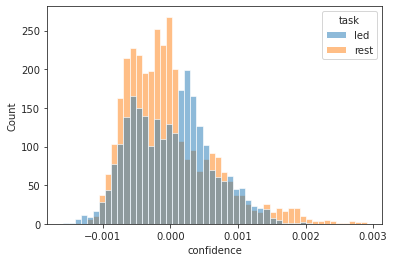

In [30]:
sns.histplot(data=result, x='confidence', hue='task')

<AxesSubplot:xlabel='confidence', ylabel='Count'>

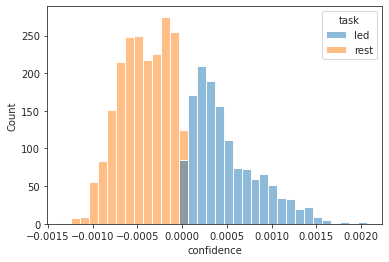

In [31]:
sns.histplot(data=result.loc[result.correct == 1], x='confidence', hue='task')

In [32]:
good_led = []
good_rest = []
for key in result.key.unique():
    _df = result.loc[result.key == key]
    percentage = collections.Counter(_df.correct).get(1, 0) / len(_df) * 100
    if percentage > 95:
        if _df.task.unique().item() == 'led':
            good_led.append(key)
        else:
            good_rest.append(key)

good_led = sorted(good_led)
good_rest = sorted(good_rest)

In [33]:
np.round(len(good_rest) / len(rest_ids) * 100), np.round(len(good_led) / len(led_ids) * 100)

(55.0, 46.0)

In [34]:
len(good_rest)

63

In [191]:
collections.Counter([e.split('_')[0] for e in good_rest]).most_common()

[
    ('sub-SLC01', 9),
    ('sub-SLC09', 8),
    ('sub-SLC10', 8),
    ('sub-SLC02', 7),
    ('sub-SLC04', 6),
    ('sub-SLC07', 6),
    ('sub-SLC08', 6),
    ('sub-SLC05', 5),
    ('sub-SLC03', 4),
    ('sub-SLC06', 4)
]

In [195]:
[e for e in good_rest if 'sub-SLC02' in e]

[
    'sub-SLC02_ses-1_run-1',
    'sub-SLC02_ses-1_run-3',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC02_ses-3_run-1',
    'sub-SLC02_ses-3_run-3'
]

In [198]:
gamma = [0.20000, 0.20000, 0.20000, 0.20000, 67.70000]
[np.round(e / sum(gamma), 3) for e in gamma]

[0.003, 0.003, 0.003, 0.003, 0.988]

In [188]:
good_rest, good_led

(
    [
        'sub-SLC01_ses-1_run-1',
        'sub-SLC01_ses-1_run-3',
        'sub-SLC01_ses-1_run-7',
        'sub-SLC01_ses-2_run-5',
        'sub-SLC01_ses-2_run-7',
        'sub-SLC01_ses-3_run-1',
        'sub-SLC01_ses-3_run-3',
        'sub-SLC01_ses-3_run-5',
        'sub-SLC01_ses-3_run-7',
        'sub-SLC02_ses-1_run-1',
        'sub-SLC02_ses-1_run-3',
        'sub-SLC02_ses-1_run-5',
        'sub-SLC02_ses-1_run-7',
        'sub-SLC02_ses-2_run-1',
        'sub-SLC02_ses-3_run-1',
        'sub-SLC02_ses-3_run-3',
        'sub-SLC03_ses-1_run-2',
        'sub-SLC03_ses-1_run-6',
        'sub-SLC03_ses-2_run-1',
        'sub-SLC03_ses-3_run-1',
        'sub-SLC04_ses-1_run-1',
        'sub-SLC04_ses-2_run-3',
        'sub-SLC04_ses-2_run-5',
        'sub-SLC04_ses-2_run-7',
        'sub-SLC04_ses-3_run-1',
        'sub-SLC04_ses-3_run-3',
        'sub-SLC05_ses-1_run-1',
        'sub-SLC05_ses-2_run-1',
        'sub-SLC05_ses-2_run-3',
        'sub-SLC05_ses-2_run-5',
        'sub-SLC05_ses-3_run-1',
        'sub-SLC06_ses-2_run-1',
        'sub-SLC06_ses-2_run-7',
        'sub-SLC06_ses-3_run-1',
        'sub-SLC06_ses-3_run-3',
        'sub-SLC07_ses-1_run-1',
        'sub-SLC07_ses-2_run-1',
        'sub-SLC07_ses-2_run-3',
        'sub-SLC07_ses-2_run-7',
        'sub-SLC07_ses-3_run-1',
        'sub-SLC07_ses-3_run-5',
        'sub-SLC08_ses-1_run-3',
        'sub-SLC08_ses-2_run-1',
        'sub-SLC08_ses-2_run-3',
        'sub-SLC08_ses-2_run-5',
        'sub-SLC08_ses-3_run-1',
        'sub-SLC08_ses-3_run-7',
        'sub-SLC09_ses-1_run-1',
        'sub-SLC09_ses-1_run-5',
        'sub-SLC09_ses-1_run-7',
        'sub-SLC09_ses-2_run-1',
        'sub-SLC09_ses-2_run-3',
        'sub-SLC09_ses-2_run-7',
        'sub-SLC09_ses-3_run-5',
        'sub-SLC09_ses-3_run-7',
        'sub-SLC10_ses-1_run-1',
        'sub-SLC10_ses-1_run-3',
        'sub-SLC10_ses-1_run-5',
        'sub-SLC10_ses-1_run-7',
        'sub-SLC10_ses-2_run-3',
        'sub-SLC10_ses-2_run-5',
        'sub-SLC10_ses-3_run-1',
        'sub-SLC10_ses-3_run-3'
    ],
    [
        'sub-SLC01_ses-1_run-2',
        'sub-SLC01_ses-1_run-6',
        'sub-SLC01_ses-2_run-4',
        'sub-SLC02_ses-1_run-2',
        'sub-SLC02_ses-1_run-4',
        'sub-SLC02_ses-2_run-2',
        'sub-SLC02_ses-2_run-4',
        'sub-SLC02_ses-2_run-6',
        'sub-SLC02_ses-2_run-7',
        'sub-SLC02_ses-3_run-4',
        'sub-SLC03_ses-1_run-3',
        'sub-SLC03_ses-1_run-7',
        'sub-SLC03_ses-2_run-2',
        'sub-SLC03_ses-2_run-4',
        'sub-SLC03_ses-2_run-6',
        'sub-SLC03_ses-3_run-4',
        'sub-SLC03_ses-3_run-6',
        'sub-SLC04_ses-1_run-6',
        'sub-SLC04_ses-3_run-6',
        'sub-SLC05_ses-1_run-4',
        'sub-SLC05_ses-3_run-2',
        'sub-SLC05_ses-3_run-4',
        'sub-SLC06_ses-1_run-2',
        'sub-SLC06_ses-1_run-4',
        'sub-SLC06_ses-1_run-6',
        'sub-SLC06_ses-2_run-2',
        'sub-SLC06_ses-3_run-4',
        'sub-SLC07_ses-1_run-2',
        'sub-SLC07_ses-1_run-6',
        'sub-SLC07_ses-2_run-2',
        'sub-SLC07_ses-3_run-2',
        'sub-SLC08_ses-1_run-4',
        'sub-SLC08_ses-1_run-6',
        'sub-SLC08_ses-2_run-2',
        'sub-SLC08_ses-2_run-4',
        'sub-SLC08_ses-2_run-6',
        'sub-SLC08_ses-3_run-2',
        'sub-SLC08_ses-3_run-6',
        'sub-SLC09_ses-2_run-4',
        'sub-SLC09_ses-3_run-2',
        'sub-SLC10_ses-2_run-6'
    ]
)

In [44]:
bad_led = []
bad_rest = []
for key in result.key.unique():
    _df = result.loc[result.key == key]
    percentage = collections.Counter(_df.correct).get(1, 0) / len(_df) * 100
    if percentage < 60:
        if _df.task.unique().item() == 'led':
            bad_led.append(key)
        else:
            bad_rest.append(key)

bad_led = sorted(bad_led)
bad_rest = sorted(bad_rest)

In [46]:
bad_led, bad_rest

(
    [
        'sub-SLC01_ses-1_run-4',
        'sub-SLC01_ses-2_run-2',
        'sub-SLC01_ses-2_run-6',
        'sub-SLC01_ses-3_run-2',
        'sub-SLC01_ses-3_run-4',
        'sub-SLC01_ses-3_run-6',
        'sub-SLC02_ses-1_run-6',
        'sub-SLC02_ses-3_run-2',
        'sub-SLC03_ses-1_run-5',
        'sub-SLC04_ses-1_run-2',
        'sub-SLC04_ses-1_run-4',
        'sub-SLC04_ses-2_run-2',
        'sub-SLC04_ses-2_run-4',
        'sub-SLC04_ses-2_run-6',
        'sub-SLC04_ses-3_run-2',
        'sub-SLC04_ses-3_run-4',
        'sub-SLC05_ses-1_run-2',
        'sub-SLC05_ses-1_run-6',
        'sub-SLC05_ses-2_run-2',
        'sub-SLC05_ses-2_run-4',
        'sub-SLC05_ses-3_run-6',
        'sub-SLC06_ses-2_run-4',
        'sub-SLC06_ses-2_run-6',
        'sub-SLC06_ses-3_run-6',
        'sub-SLC07_ses-1_run-4',
        'sub-SLC07_ses-2_run-4',
        'sub-SLC07_ses-2_run-6',
        'sub-SLC07_ses-3_run-4',
        'sub-SLC07_ses-3_run-6',
        'sub-SLC08_ses-1_run-2',
        'sub-SLC09_ses-1_run-2',
        'sub-SLC09_ses-1_run-4',
        'sub-SLC09_ses-1_run-6',
        'sub-SLC09_ses-2_run-2',
        'sub-SLC09_ses-2_run-6',
        'sub-SLC09_ses-3_run-4',
        'sub-SLC09_ses-3_run-6',
        'sub-SLC10_ses-1_run-2',
        'sub-SLC10_ses-1_run-4',
        'sub-SLC10_ses-1_run-6',
        'sub-SLC10_ses-2_run-2',
        'sub-SLC10_ses-2_run-4',
        'sub-SLC10_ses-3_run-2',
        'sub-SLC10_ses-3_run-4',
        'sub-SLC10_ses-3_run-6'
    ],
    [
        'sub-SLC01_ses-1_run-5',
        'sub-SLC01_ses-2_run-1',
        'sub-SLC01_ses-2_run-3',
        'sub-SLC02_ses-2_run-3',
        'sub-SLC02_ses-2_run-5',
        'sub-SLC02_ses-3_run-5',
        'sub-SLC02_ses-3_run-7',
        'sub-SLC03_ses-1_run-4',
        'sub-SLC03_ses-2_run-3',
        'sub-SLC03_ses-2_run-5',
        'sub-SLC03_ses-2_run-7',
        'sub-SLC03_ses-3_run-5',
        'sub-SLC03_ses-3_run-7',
        'sub-SLC04_ses-1_run-3',
        'sub-SLC04_ses-1_run-5',
        'sub-SLC04_ses-3_run-5',
        'sub-SLC04_ses-3_run-7',
        'sub-SLC05_ses-1_run-3',
        'sub-SLC05_ses-1_run-7',
        'sub-SLC05_ses-2_run-7',
        'sub-SLC05_ses-3_run-3',
        'sub-SLC05_ses-3_run-5',
        'sub-SLC05_ses-3_run-7',
        'sub-SLC06_ses-1_run-1',
        'sub-SLC06_ses-1_run-3',
        'sub-SLC06_ses-1_run-5',
        'sub-SLC06_ses-1_run-7',
        'sub-SLC06_ses-2_run-3',
        'sub-SLC06_ses-2_run-5',
        'sub-SLC06_ses-3_run-5',
        'sub-SLC06_ses-3_run-7',
        'sub-SLC07_ses-1_run-3',
        'sub-SLC07_ses-1_run-7',
        'sub-SLC07_ses-2_run-5',
        'sub-SLC07_ses-3_run-3',
        'sub-SLC08_ses-1_run-5',
        'sub-SLC08_ses-2_run-7',
        'sub-SLC08_ses-3_run-3',
        'sub-SLC08_ses-3_run-5',
        'sub-SLC09_ses-1_run-3',
        'sub-SLC09_ses-2_run-5',
        'sub-SLC09_ses-3_run-3',
        'sub-SLC10_ses-2_run-7',
        'sub-SLC10_ses-3_run-5',
        'sub-SLC10_ses-3_run-7'
    ]
)

<AxesSubplot:xlabel='confidence', ylabel='Count'>

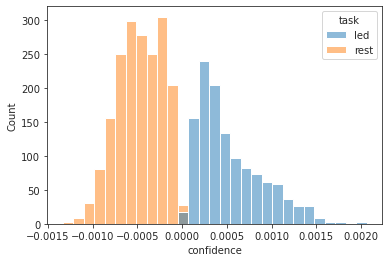

In [36]:
sns.histplot(data=result.loc[result.key.isin(good_rest + good_led)], x='confidence', hue='task')

In [37]:
np.save(pjoin(tmp_dir, 'good_led_n64.npy'), good_led)
np.save(pjoin(tmp_dir, 'good_rest_n64.npy'), good_rest)

In [38]:
good_rest

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC01_ses-1_run-3',
    'sub-SLC01_ses-1_run-7',
    'sub-SLC01_ses-2_run-5',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC01_ses-3_run-1',
    'sub-SLC01_ses-3_run-3',
    'sub-SLC01_ses-3_run-5',
    'sub-SLC01_ses-3_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC02_ses-1_run-3',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC02_ses-3_run-1',
    'sub-SLC02_ses-3_run-3',
    'sub-SLC03_ses-1_run-2',
    'sub-SLC03_ses-1_run-6',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC03_ses-3_run-1',
    'sub-SLC04_ses-1_run-1',
    'sub-SLC04_ses-2_run-3',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC04_ses-2_run-7',
    'sub-SLC04_ses-3_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC05_ses-1_run-1',
    'sub-SLC05_ses-2_run-1',
    'sub-SLC05_ses-2_run-3',
    'sub-SLC05_ses-2_run-5',
    'sub-SLC05_ses-3_run-1',
    'sub-SLC06_ses-2_run-1',
    'sub-SLC06_ses-2_run-7',
    'sub-SLC06_ses-3_run-1',
    'sub-SLC06_ses-3_run-3',
    'sub-SLC07_ses-1_run-1',
    'sub-SLC07_ses-2_run-1',
    'sub-SLC07_ses-2_run-3',
    'sub-SLC07_ses-2_run-7',
    'sub-SLC07_ses-3_run-1',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC08_ses-2_run-1',
    'sub-SLC08_ses-2_run-3',
    'sub-SLC08_ses-2_run-5',
    'sub-SLC08_ses-3_run-1',
    'sub-SLC08_ses-3_run-7',
    'sub-SLC09_ses-1_run-1',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC09_ses-1_run-7',
    'sub-SLC09_ses-2_run-1',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC09_ses-2_run-7',
    'sub-SLC09_ses-3_run-5',
    'sub-SLC09_ses-3_run-7',
    'sub-SLC10_ses-1_run-1',
    'sub-SLC10_ses-1_run-3',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC10_ses-1_run-7',
    'sub-SLC10_ses-2_run-3',
    'sub-SLC10_ses-2_run-5',
    'sub-SLC10_ses-3_run-1',
    'sub-SLC10_ses-3_run-3'
]

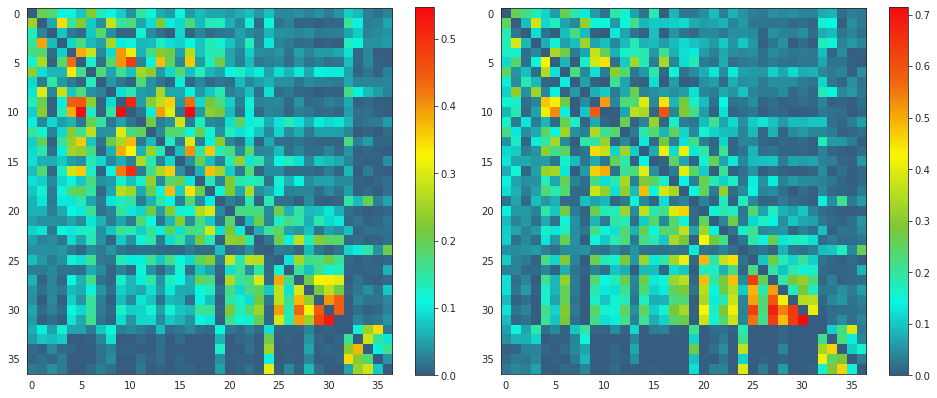

In [49]:
a = []
for k in good_rest:
    a.append(np.expand_dims(within_all[f"rest:{k}"], 0))
a = np.concatenate(a)

b = []
for k in good_led:
    b.append(np.expand_dims(within_all[f"led:{k}"], 0))
b = np.concatenate(b)


fig, axes = create_figure(1, 2, (13.5, 5.5))

im = axes[0].imshow(a.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(b.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[1])
plt.show()

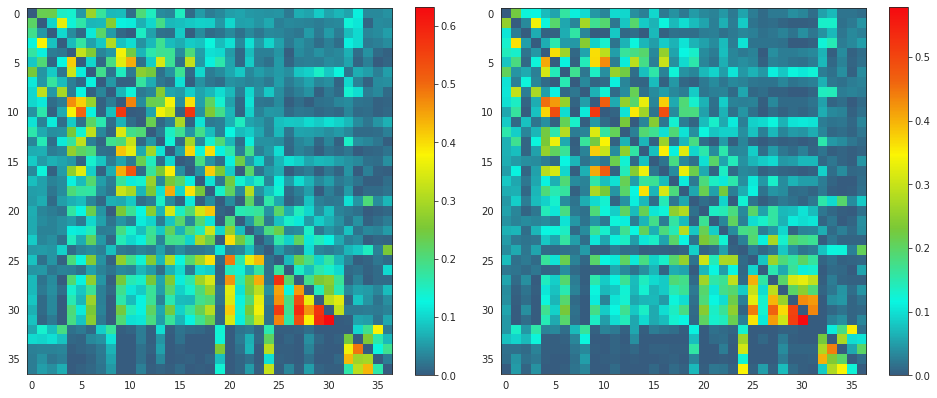

In [50]:
a = []
for k in bad_rest:
    a.append(np.expand_dims(within_all[f"rest:{k}"], 0))
a = np.concatenate(a)

b = []
for k in bad_led:
    b.append(np.expand_dims(within_all[f"led:{k}"], 0))
b = np.concatenate(b)


fig, axes = create_figure(1, 2, (13.5, 5.5))

im = axes[0].imshow(a.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(b.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[1])
plt.show()

<matplotlib.image.AxesImage object at 0x7f032bb09880>

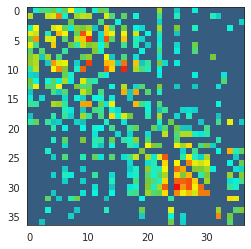

In [51]:
# k = 'sub-SLC03_ses-1_run-4'
k = 'sub-SLC07_ses-1_run-7'
plt.imshow(within_all[f"rest:{k}"], cmap=net.style['cmap'])

In [174]:
task = 'rest'
mice = Mice(Config(64), load_preproc=True)
mice.combine_dfs(task, full=True)

In [187]:
dl = []
for key, f in tqdm(mice.bold_preproc.items()):
    x = f.get_data()
    if x is None:
        continue
    sub, ses, run = mice.looper[key]
    dd = {
        'sub': [sub],
        'ses': [ses],
        'run': [run],
        'task': [f.task],
        'var': [x.var()],
        'mean': [x.mean()],
    }
    dl.append(dd)
df = pd.DataFrame(merge_dicts(dl))

  0%|          | 0/210 [00:00<?, ?it/s]

In [161]:
stim_on_global = [20 + i * 60 for i in range(9)] + [47 + i * 60 for i in range(9)]
stim_on_global

[
    20,
    80,
    140,
    200,
    260,
    320,
    380,
    440,
    500,
    47,
    107,
    167,
    227,
    287,
    347,
    407,
    467,
    527
]

In [163]:
potential_stim_times = [list(range(on, on + 15)) for on in stim_on_global]
potential_stim_times = [e for item in potential_stim_times for e in item]
potential_stim_times = np.array(sorted(potential_stim_times))
potential_stim_times = potential_stim_times[potential_stim_times < 550]
len(potential_stim_times)

270

In [167]:
df.iloc[np.delete(range(len(df)), potential_stim_times)]

region_id,0-315-1,0-315-2,0-315-3,0-315-4,0-315-5,0-315-6,0-315-7,0-315-8,0-315-9,0-315-10,...,1-315-60,1-315-61,1-315-62,1-315-63,1-315-64,1-477,1-698,1-703,1-803,1-1089
timepoint,,,,,,,,,,,,,,,,,,,,,
1250,-0.550231,0.115993,-0.340231,-0.001564,0.002181,0.368307,-0.015985,0.145857,-0.075349,-0.224645,...,0.018468,0.255008,0.208175,1.042013,0.447566,-0.172299,0.157579,0.197967,-0.155134,0.014754
1251,-0.795173,0.014178,-0.069353,-0.265084,-0.161326,-0.156525,-0.075943,0.644284,0.220126,-0.418786,...,0.425132,-0.061392,0.283065,0.677013,0.487644,-0.139205,0.182586,0.009644,-0.022493,0.090358
1252,-0.286228,-0.208058,0.338311,-0.268461,-0.163198,-0.344904,0.029123,0.442150,0.439705,-0.331652,...,0.438837,-0.279826,0.361636,0.816948,0.433097,-0.127162,0.087983,-0.229252,-0.042542,0.159030
1253,0.169453,0.063292,0.395070,-0.208455,-0.482328,-0.550362,0.106240,0.280147,-0.060232,-0.251551,...,0.521419,-0.209842,0.561964,0.989418,1.015688,-0.101832,-0.007525,-0.229471,-0.104684,0.137866
1254,0.256724,0.308786,0.690119,-0.546522,-0.685376,-0.539577,-0.024167,0.149444,-0.611656,-0.457410,...,0.540858,0.056253,0.829951,0.897301,1.375883,-0.060269,-0.074499,-0.144677,0.028245,0.093589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.561290,-0.019719,-0.537977,-0.768602,0.218936,-0.392060,0.005363,-0.374251,-0.077620,0.095838,...,-0.817648,-1.618496,-0.404272,-0.716022,-0.704818,-0.217218,-0.075156,-0.055870,-0.286108,-0.064462
1796,0.397751,0.129740,-1.167835,-0.785317,-0.166962,-0.974659,0.111153,-0.812420,-0.147951,0.196382,...,-0.367029,-1.409675,-0.205299,-0.831952,-0.813750,-0.160170,-0.029666,0.036952,-0.148234,-0.012560
1797,-0.181146,0.361215,-1.217243,-0.692078,-0.135577,-0.644266,0.405110,-0.381195,0.002460,0.139909,...,-0.150467,-0.567992,0.044594,-0.669133,-0.929109,-0.020093,-0.118246,-0.018730,0.019065,0.022409


In [169]:
b.shape

(37, 37)

In [165]:
k = 'sub-SLC09_ses-1_run-3'
df = mice.bold_combined[k]

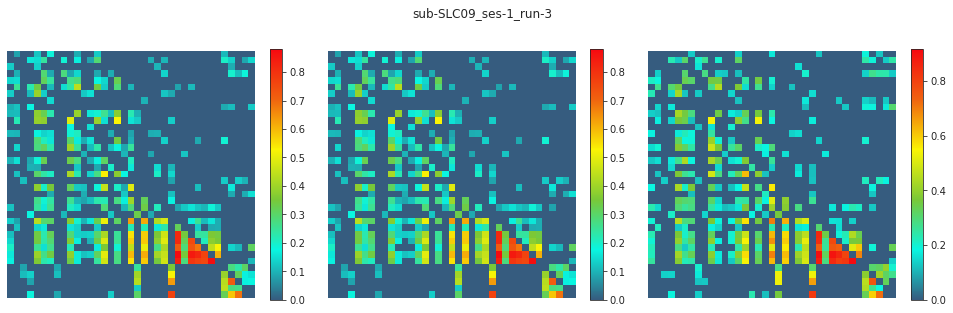

In [166]:
df = mice.bold_combined[k]

### All
a, _ = get_adj_mat(df, 'pearson')
a[a < 0] = 0.
a, _ = net.get_hemisphere_adj(a)
np.fill_diagonal(a, 0.)

### Removed
b, p = get_adj_mat(df.iloc[np.delete(range(len(df)), potential_stim_times)], 'pearson')
b[b < 0] = 0.
b, _ = net.get_hemisphere_adj(b)
np.fill_diagonal(b, 0.)


fig, axes = create_figure(1, 3, (13.5, 4.5))
im1 = axes[0].imshow(within_all[f"rest:{k}"], cmap=net.style['cmap'])
plt.colorbar(im1, ax=axes[0], shrink=0.9)
im2 = axes[1].imshow(a, cmap=net.style['cmap'])
plt.colorbar(im2, ax=axes[1], shrink=0.9)
im3 = axes[2].imshow(b, cmap=net.style['cmap'])
plt.colorbar(im3, ax=axes[2], shrink=0.9)
fig.suptitle(k)
remove_ticks(axes)
plt.show()

In [144]:
k = 'sub-SLC09_ses-1_run-3'
df = mice.bold_combined[k]

In [156]:
stim_on_global

[20, 80, 140, 200, 260, 320, 380, 440, 500]

<matplotlib.colorbar.Colorbar object at 0x7f03286910a0>

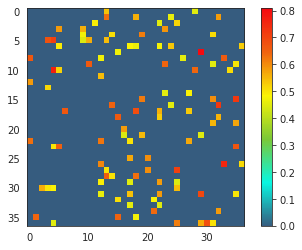

In [159]:
slide = range(160, 180)

c, _ = get_adj_mat(df.iloc[slide], 'pearson')
c[c < 0] = 0.
c, _ = net.get_hemisphere_adj(c)
np.fill_diagonal(c, 0.)
plt.imshow(c, cmap=net.style['cmap'])
plt.colorbar()

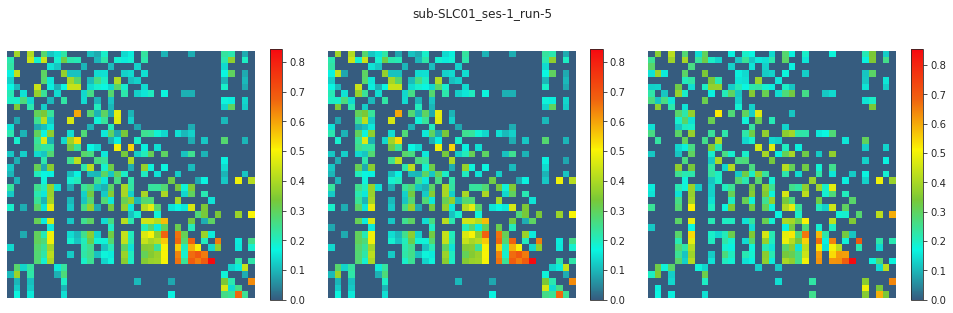

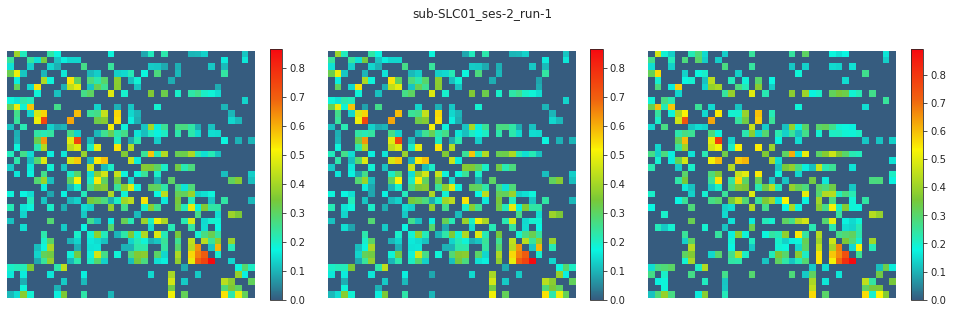

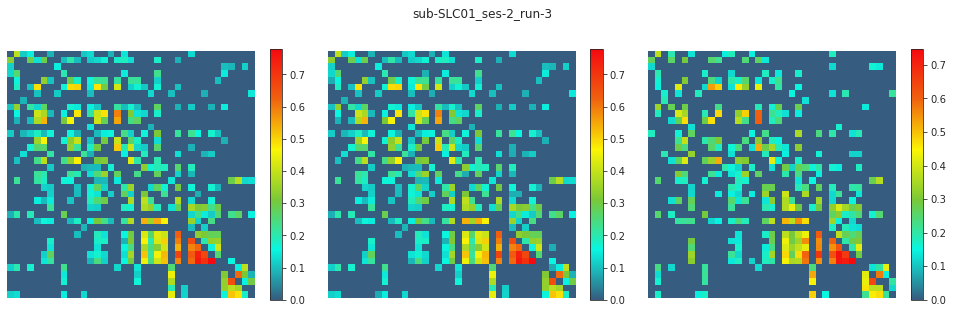

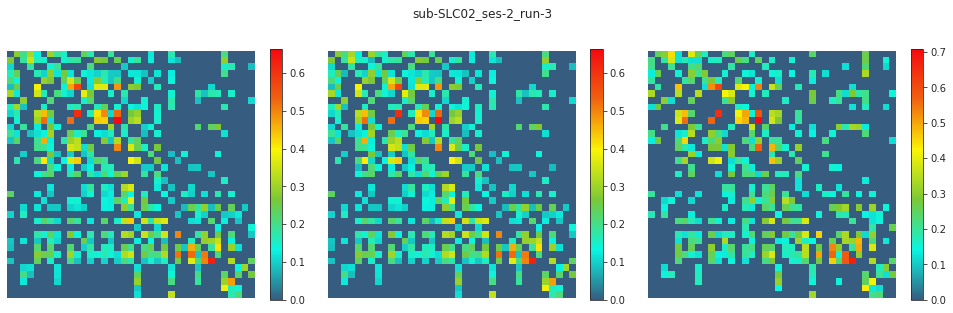

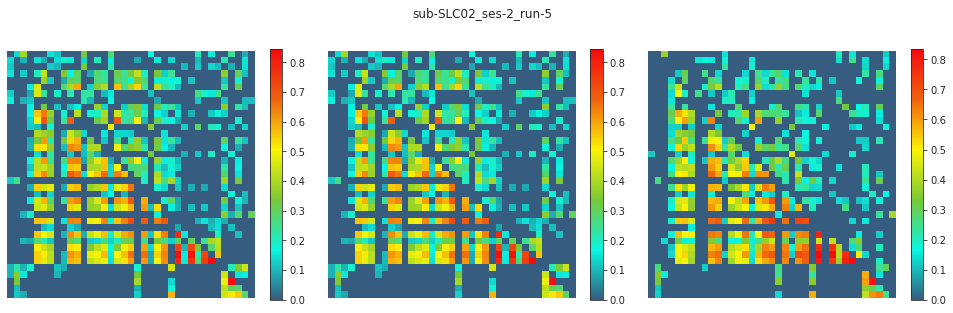

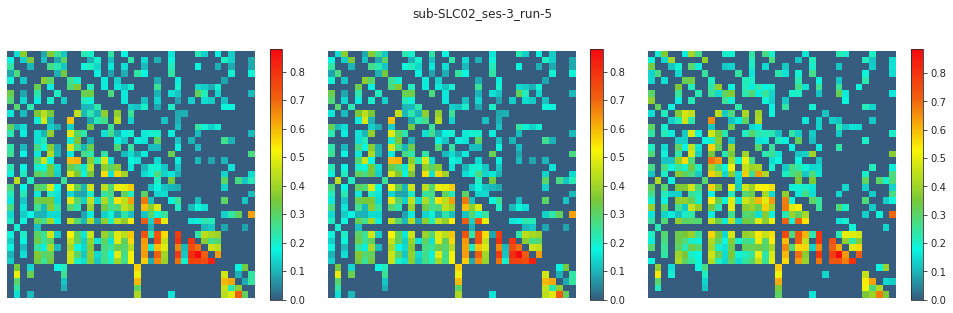

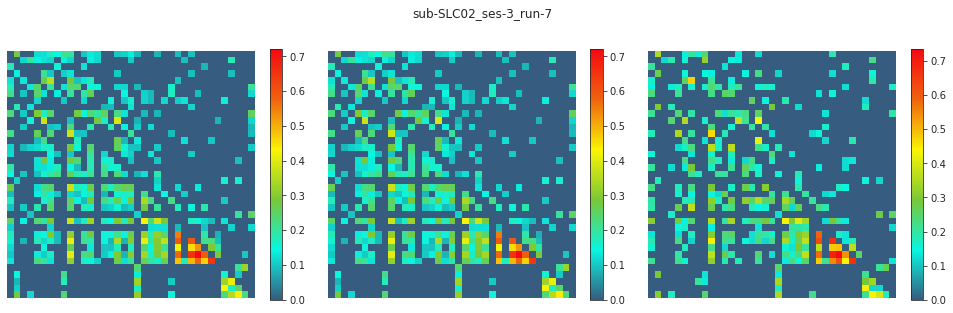

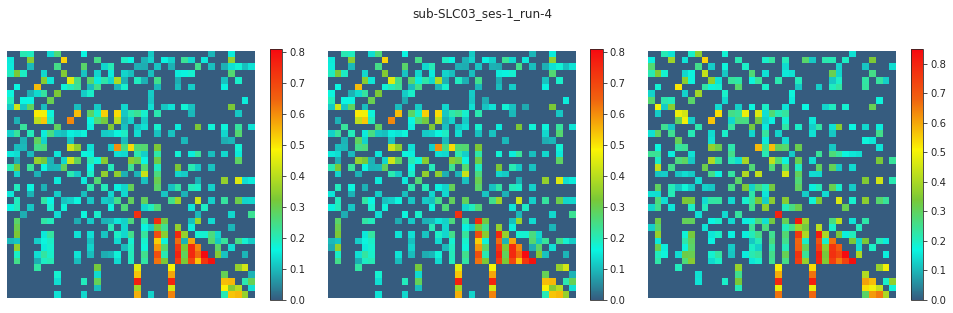

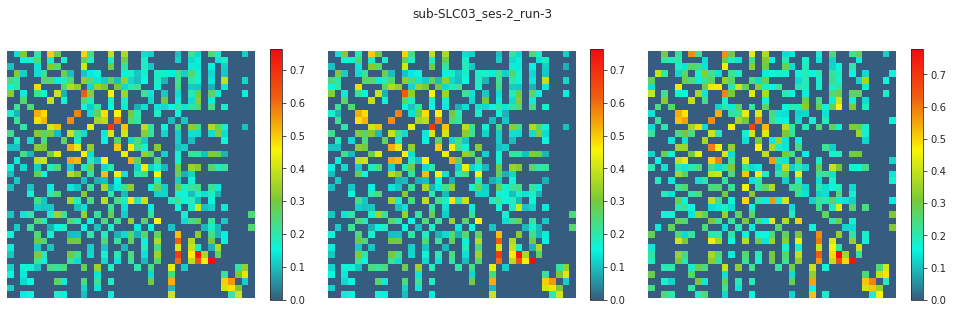

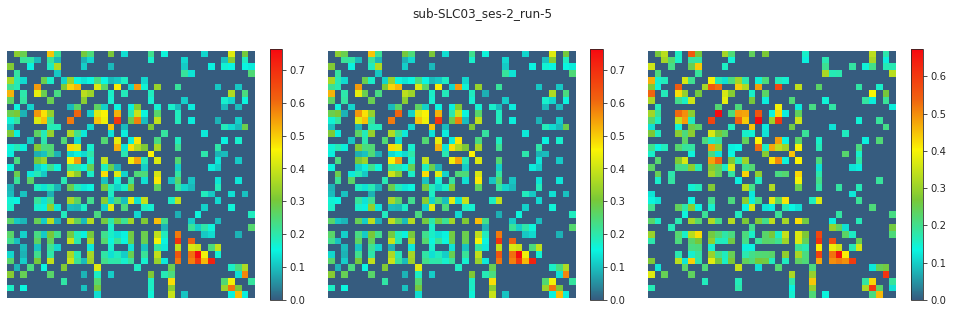

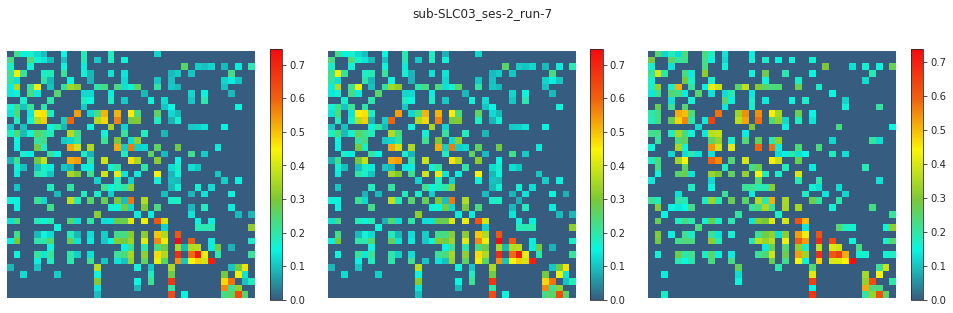

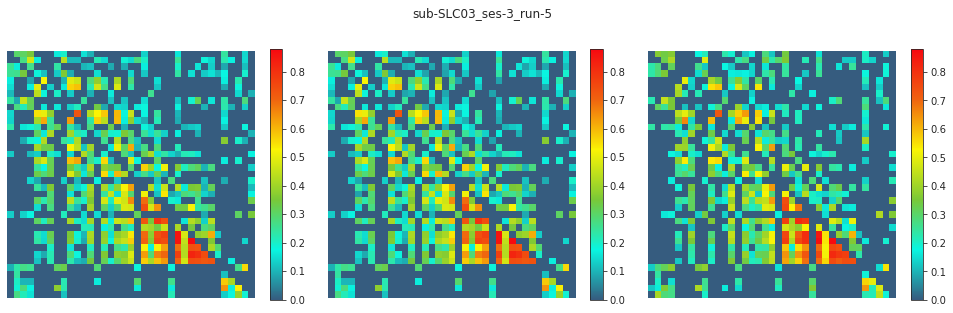

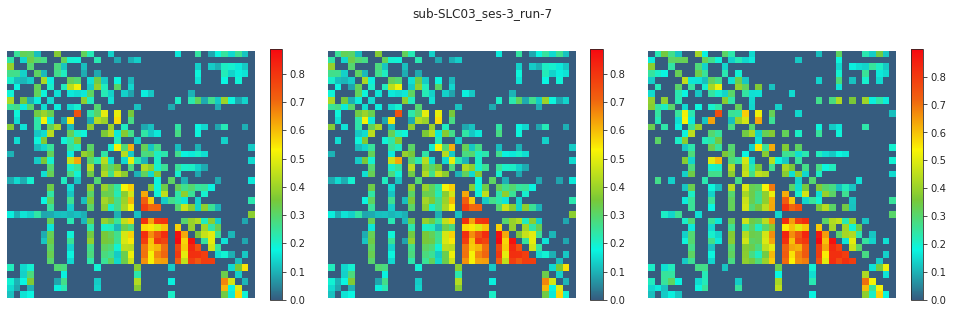

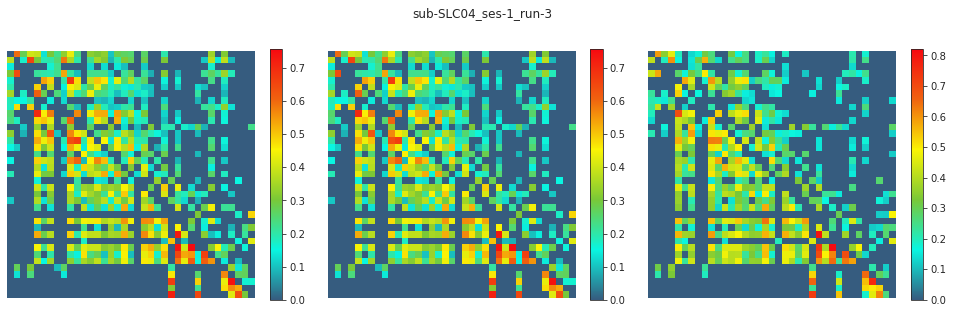

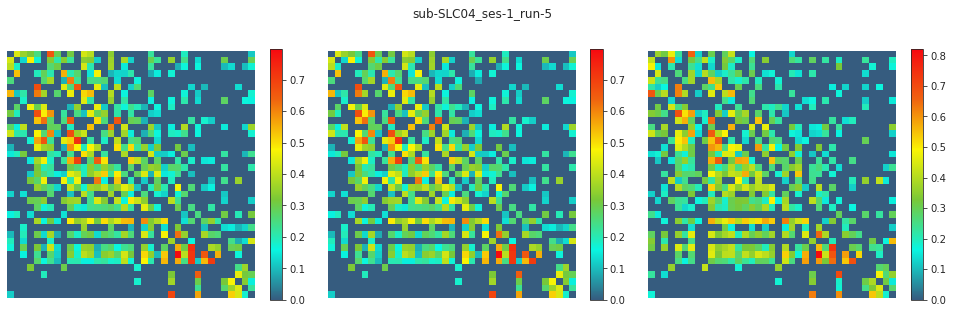

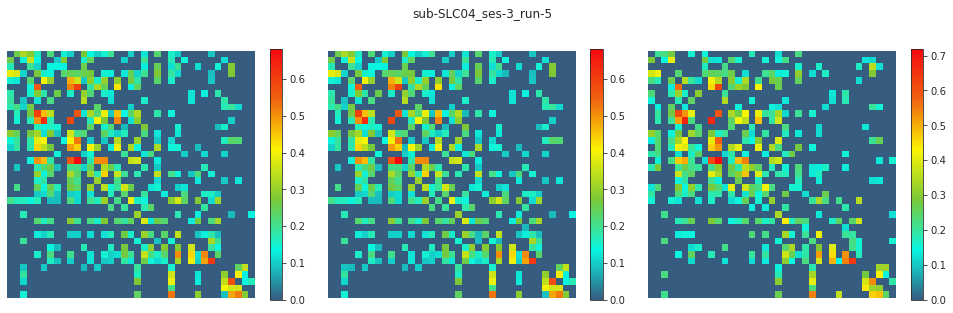

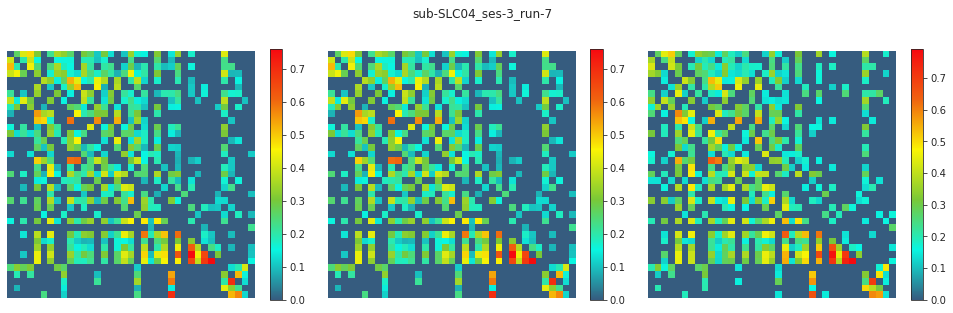

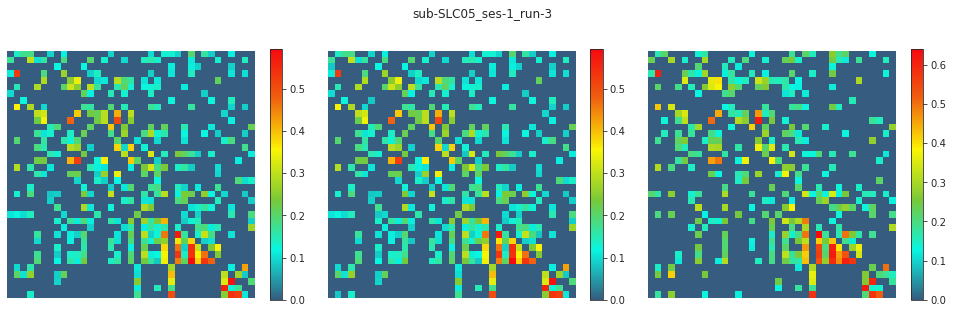

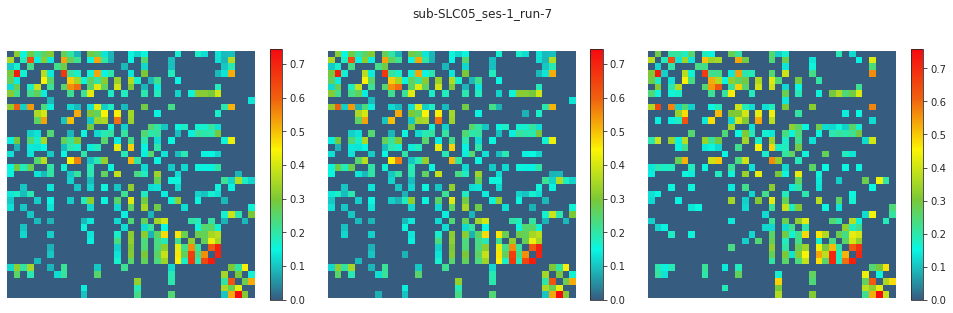

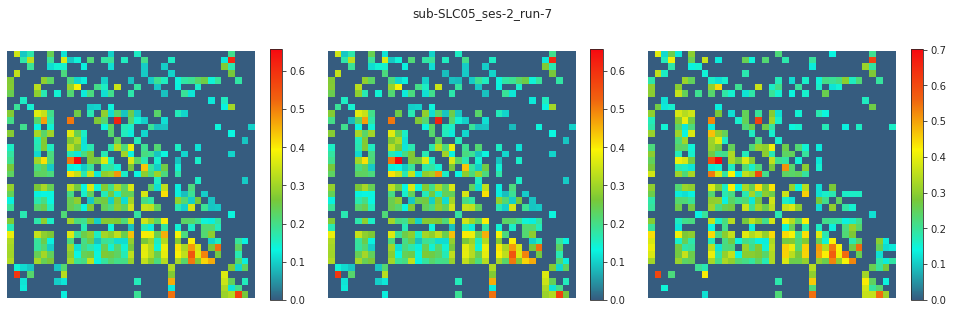

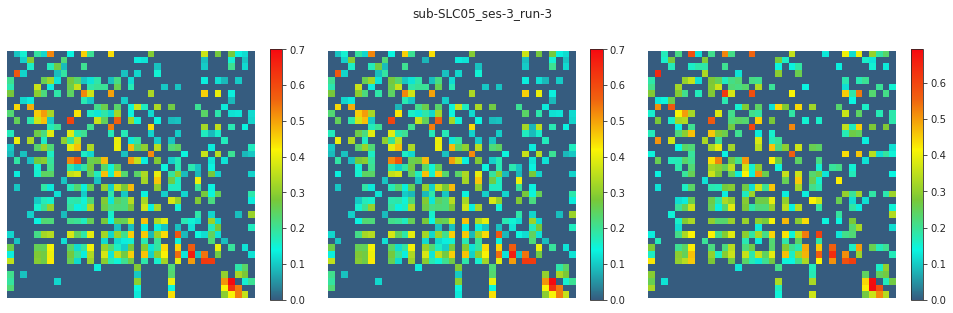

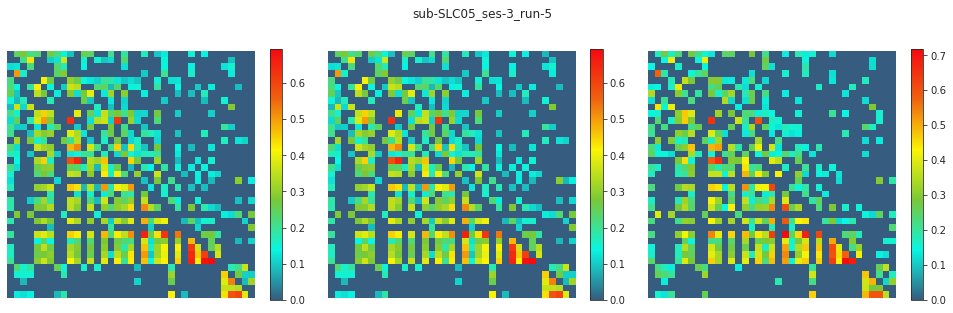

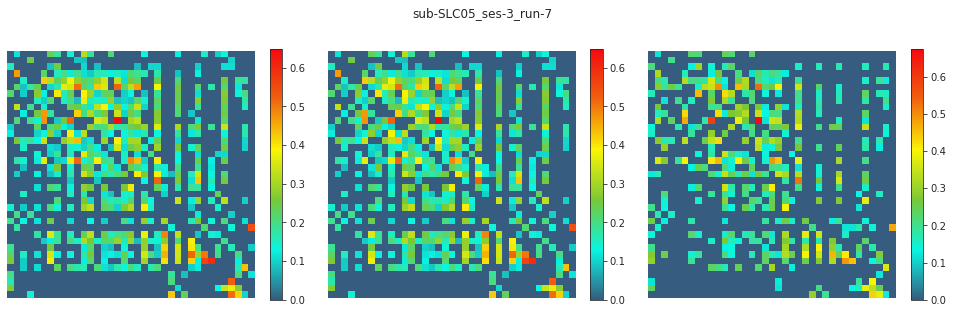

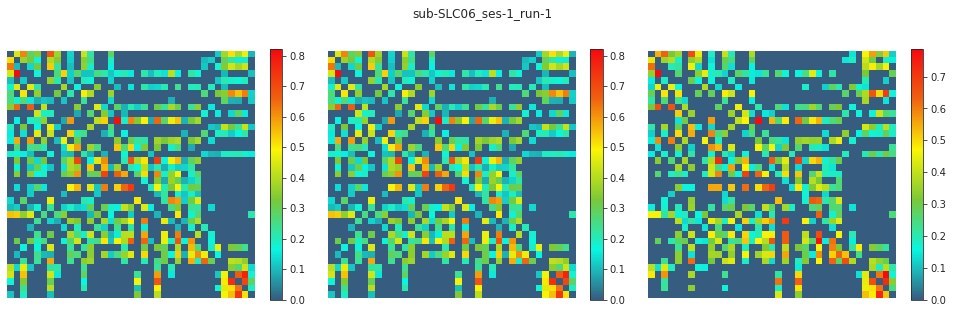

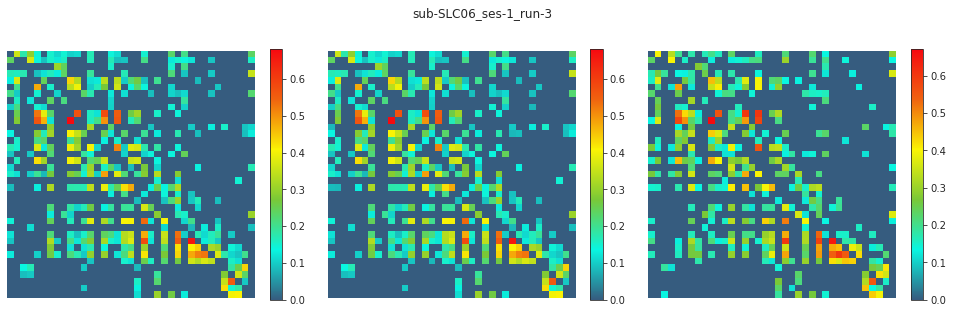

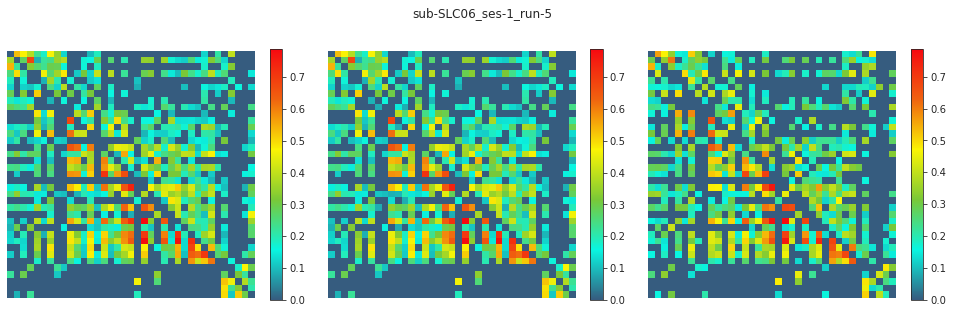

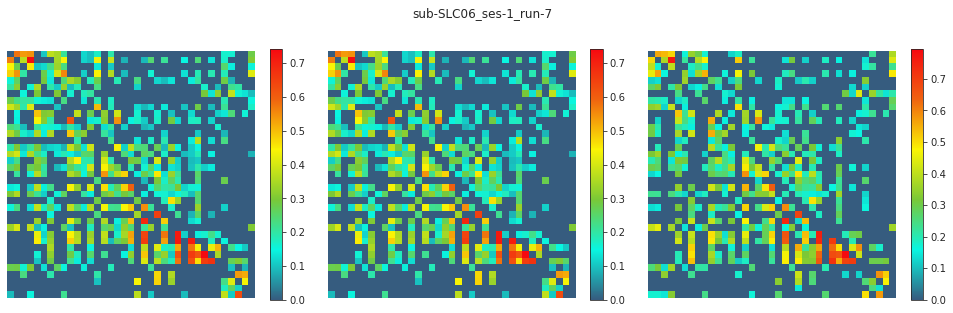

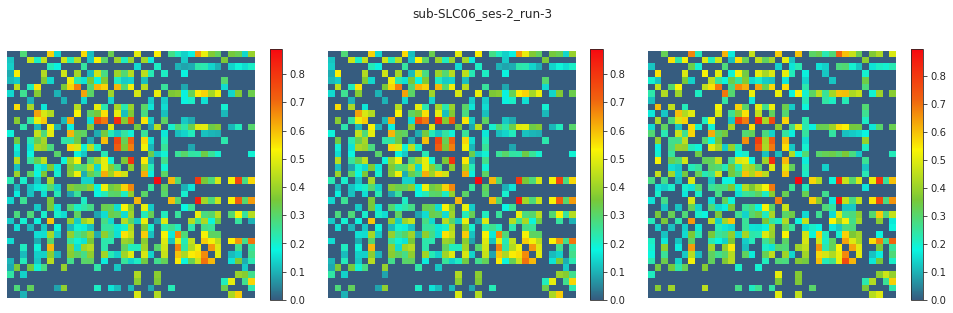

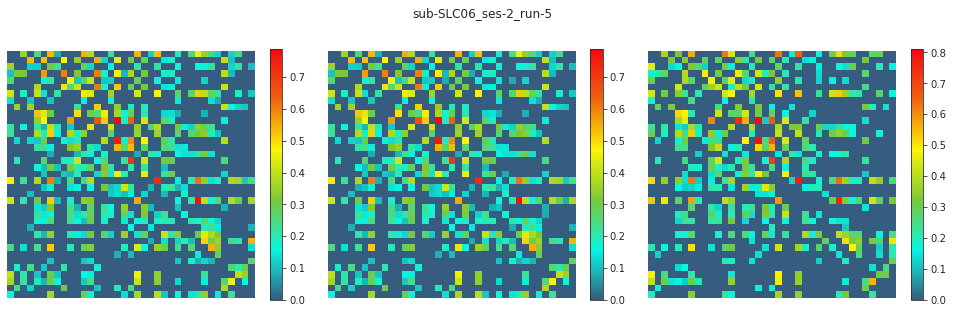

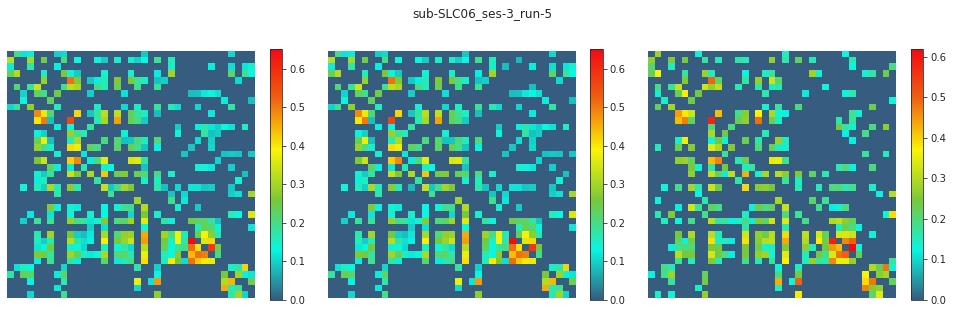

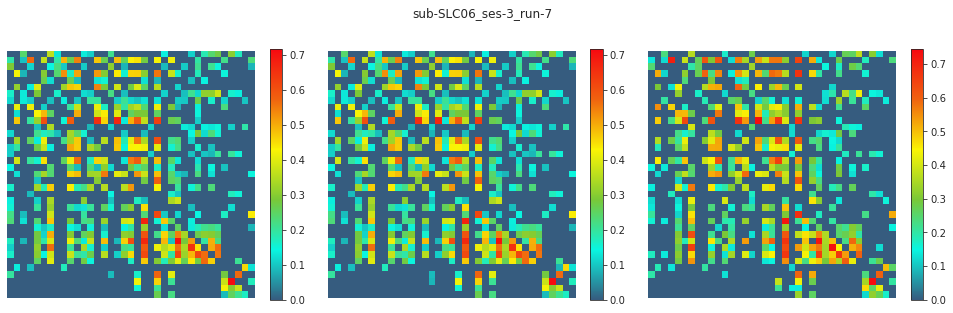

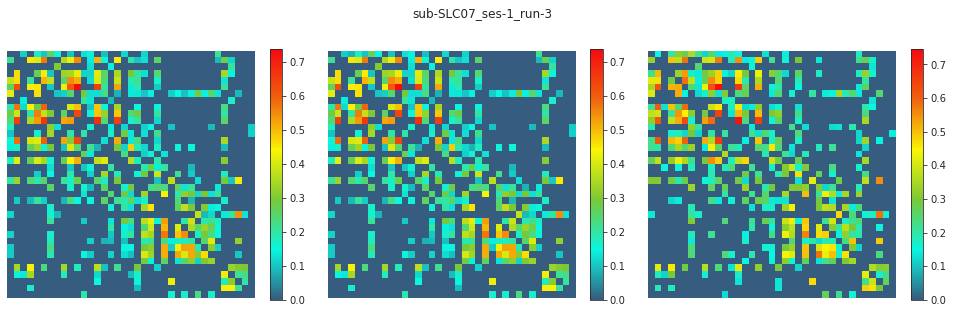

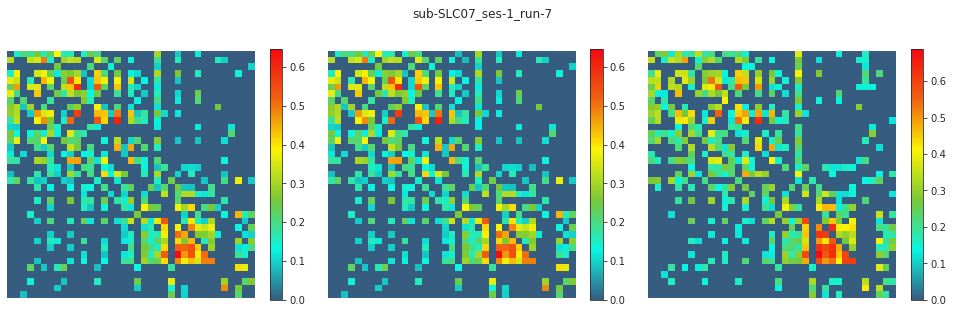

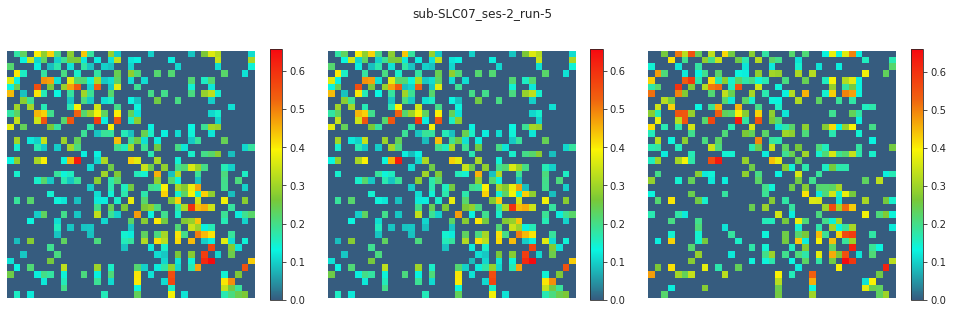

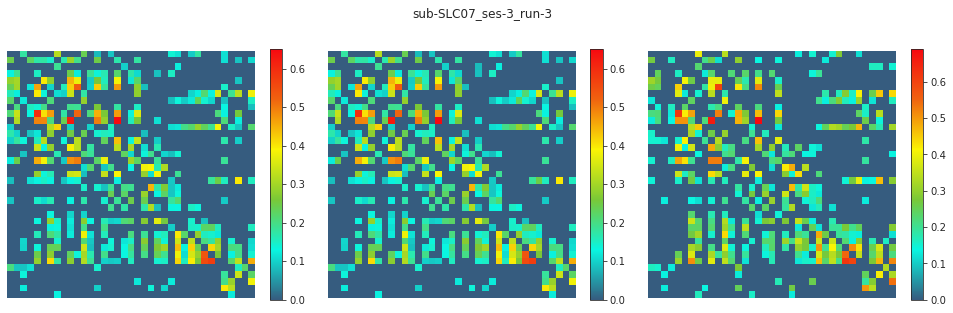

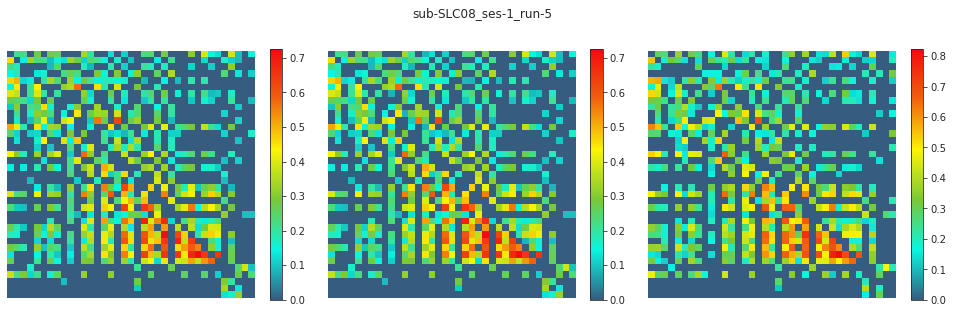

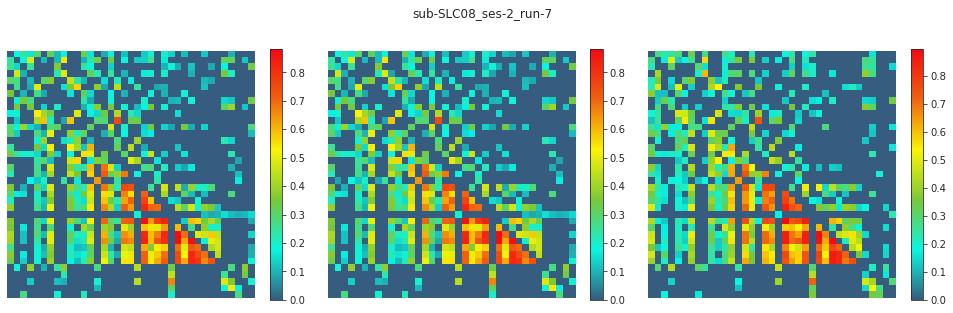

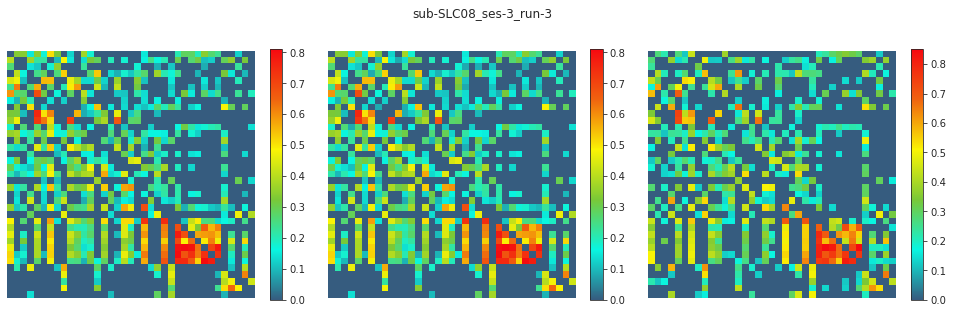

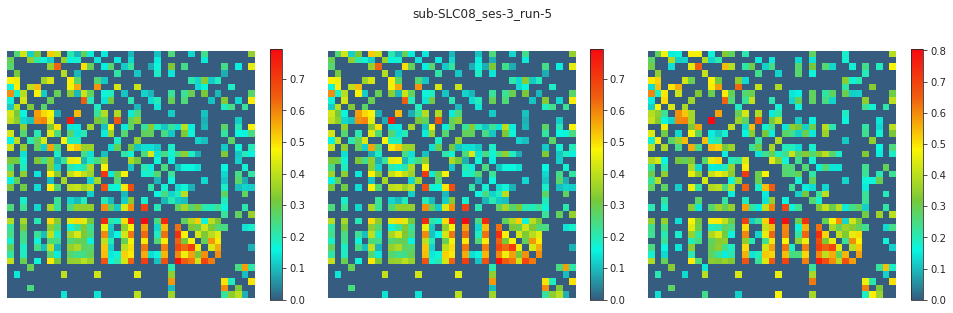

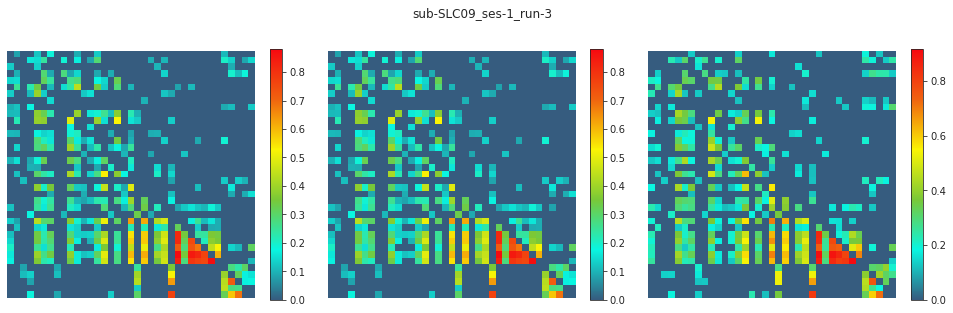

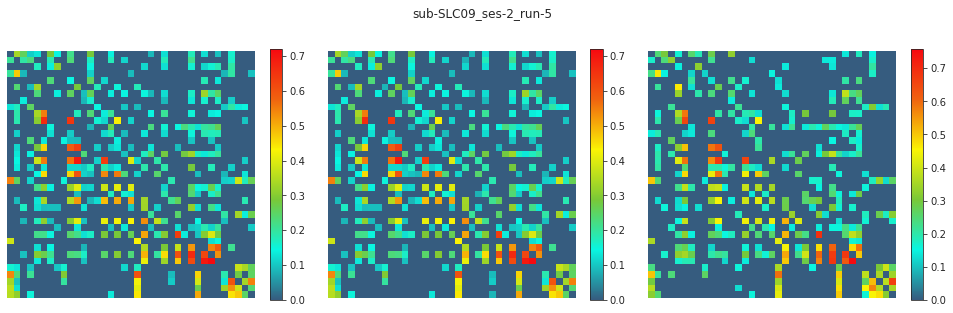

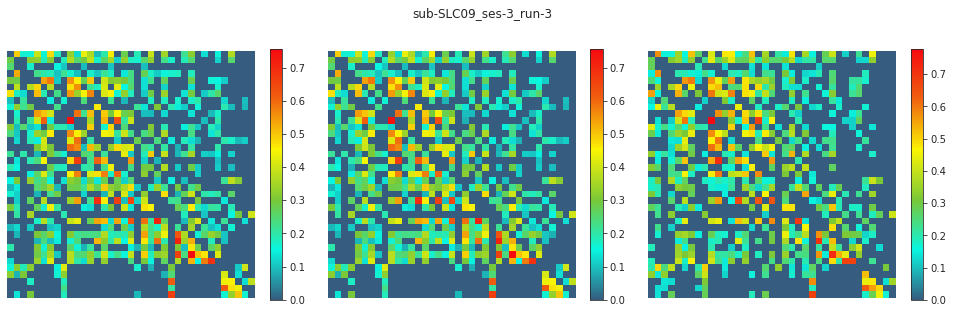

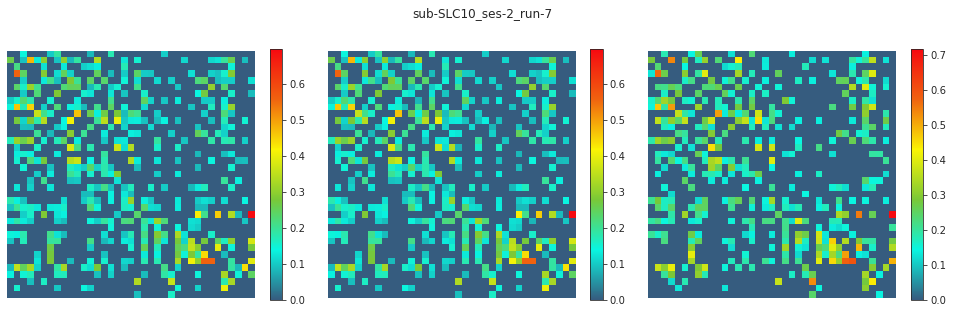

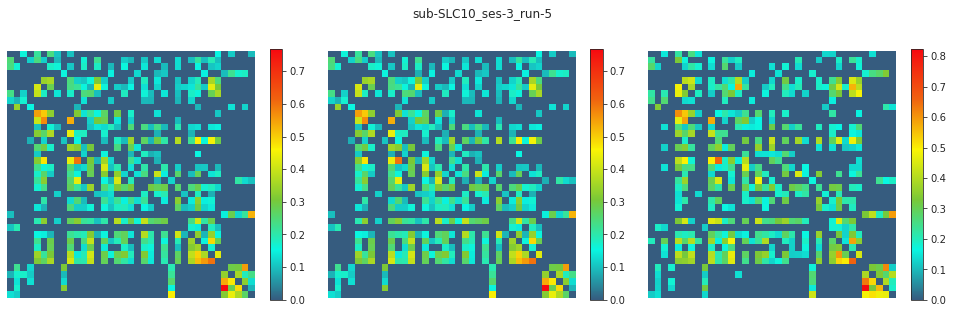

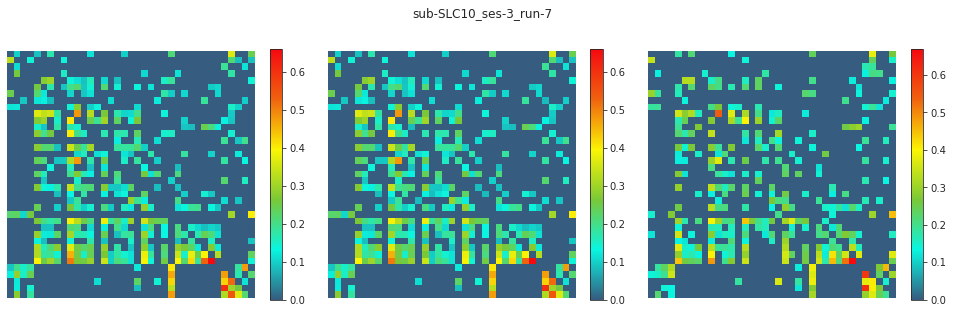

In [170]:
for k in bad_rest:
    df = mice.bold_combined[k]

    ### All
    a, p = get_adj_mat(df, 'pearson')
    a[a < 0] = 0.
    a, _ = net.get_hemisphere_adj(a)
    np.fill_diagonal(a, 0.)

    ### Removed
    b, p = get_adj_mat(df.iloc[np.delete(range(len(df)), potential_stim_times)], 'pearson')
    b[b < 0] = 0.
    b, _ = net.get_hemisphere_adj(b)
    np.fill_diagonal(b, 0.)


    fig, axes = create_figure(1, 3, (13.5, 4.5))
    im1 = axes[0].imshow(within_all[f"rest:{k}"], cmap=net.style['cmap'])
    plt.colorbar(im1, ax=axes[0], shrink=0.9)
    im2 = axes[1].imshow(a, cmap=net.style['cmap'])
    plt.colorbar(im2, ax=axes[1], shrink=0.9)
    im3 = axes[2].imshow(b, cmap=net.style['cmap'])
    plt.colorbar(im3, ax=axes[2], shrink=0.9)
    fig.suptitle(k)
    remove_ticks(axes)
    plt.show()
    
    print('\n\n')

### Condition: exclude potential

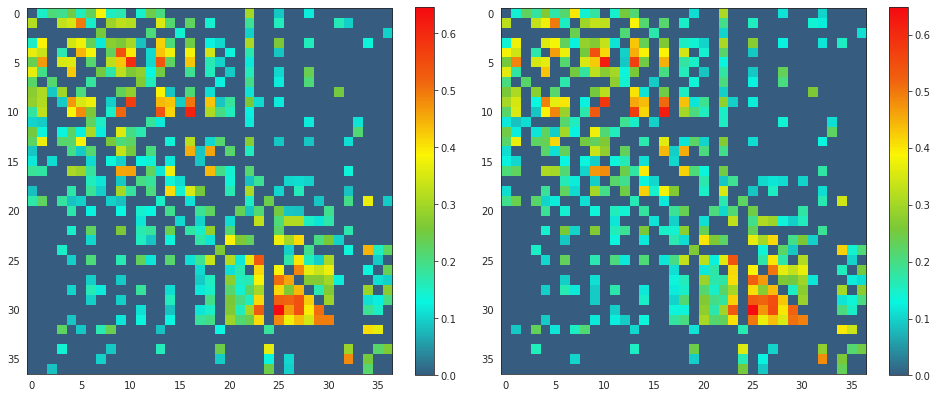

In [99]:
fig, axes = create_figure(1, 2, (13.5, 5.5))

im1 = axes[0].imshow(within_all[f"rest:{k}"], cmap=net.style['cmap'])
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(b, cmap=net.style['cmap'])
plt.colorbar(im2, ax=axes[1])
plt.show()

## SV _ GOOD _ REST

In [49]:
sv = pjoin(tmp_dir, 'good_rest_n64')
os.makedirs(sv, exist_ok=True)

In [50]:
task = 'rest'
mode = 'bold'
metric = 'pearson'

mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

In [51]:
for key in tqdm(good_rest):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    _ = net.fig_within_hemis(save_dir=sv)

  0%|          | 0/63 [00:00<?, ?it/s]

## SV _ GOOD _ LED

In [52]:
sv = pjoin(tmp_dir, 'good_led_n64')
os.makedirs(sv, exist_ok=True)

In [53]:
task = 'led'
mode = 'bold'
metric = 'pearson'

mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

In [54]:
for key in tqdm(good_led):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    _ = net.fig_within_hemis(save_dir=sv)

  0%|          | 0/41 [00:00<?, ?it/s]